<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> Tarea 3 - Ensamblados y modelos avanzados</h1>

<H3 align='center'> <i>Felipe Olavarria, Rol:201673606-9</i> </H3>
<H3 align='center'> <i>Jean Aravena, Rol:201673573-9</i> </H3>
<hr style="height:2px;border:none"/>

In [35]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Ensamblados para regresión
Las técnicas de ensamblados vistos en clases pueden ser aplicadas tanto a problemas de clasificación o regresión, teniendo la ventaja de utilizar múltiples modelos de aprendizaje para utilizar la ventaja de cada uno. En este actividad se trabajará con predecir la temperatura media de un día, dada cierta información del día anterior, como la humedad, velocidad del viento, presión atmosférica, fecha y temperatura. El modelo predictor derivado puede ser bastante útil para conocer el comportamiento del clima a lo largo del tiempo.

<img src="https://scijinks.gov/review/forecast-reliability/forecast-reliability2.jpg" title="Title text" width="70%"  />

Los datos de clima son recolectados en la ciudad Delhi de India por un período de 4 años (2013 a 2017), proporcionados en Kaggle a través del siguiente __[link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)__, las particiones de entrenamiento y prueba están dadas. El registro de cada dato corresponde a un día, incrementando a través de las filas por cada día.


>  Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.

In [36]:
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

In [37]:
df.head(5)

,date,meantemp,humidity,wind_speed,meanpressure,y_value
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.400000
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,7.166667
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,8.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,6.000000
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.000000


> Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.

In [38]:
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
#df.drop(["date"], axis=1, inplace=True) #delete date
params = ['meantemp','humidity','wind_speed','meanpressure']
cols = ['meantemp','humidity','wind_speed','meanpressure','cday','year','month','season_fall','season_rainy','season_summer','season_winter']
df[cols].head(5)

,meantemp,humidity,wind_speed,meanpressure,cday,year,month,season_fall,season_rainy,season_summer,season_winter
0,10.000000,84.500000,0.000000,1015.666667,1,2013,1,0,0,0,1
1,7.400000,92.000000,2.980000,1017.800000,2,2013,1,0,0,0,1
2,7.166667,87.000000,4.633333,1018.666667,3,2013,1,0,0,0,1
3,8.666667,71.333333,1.233333,1017.166667,4,2013,1,0,0,0,1
4,6.000000,86.833333,3.700000,1016.500000,5,2013,1,0,0,0,1


***La separación de la fecha ya realizada es acorde al problema.***

> Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.

In [39]:
y = df["y_value"].values
X = df[cols].values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only

> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.

In [40]:
df[cols].columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'cday', 'year',
       'month', 'season_fall', 'season_rainy', 'season_summer',
       'season_winter'],
      dtype='object')

In [41]:
df[cols].shape

(1461, 11)

***Tenemos 1461 datos diferentes en el dataset, cada uno con 13 atributos. Date lo dejamos para poder graficar las caracteristicas meantemp, humidity, wind_speed y meanpressure.***

In [42]:
df[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 11 columns):
meantemp         1461 non-null float64
humidity         1461 non-null float64
wind_speed       1461 non-null float64
meanpressure     1461 non-null float64
cday             1461 non-null int64
year             1461 non-null int64
month            1461 non-null int64
season_fall      1461 non-null uint8
season_rainy     1461 non-null uint8
season_summer    1461 non-null uint8
season_winter    1461 non-null uint8
dtypes: float64(4), int64(3), uint8(4)
memory usage: 85.7 KB


***Se muestra el resumen del dataframe, en el cual no existen registros nulos para ninguna de las 13 columnas.
Además se informa el tipo de dato que presenta cada una de los atributos y la memoria utilizada.***

In [43]:
df[params].describe()

,meantemp,humidity,wind_speed,meanpressure
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,25.506127,60.744851,6.806865,1011.101197
std,7.339416,16.743928,4.559688,180.293335
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.571429
50%,27.714286,62.625000,6.250000,1008.555556
75%,31.312500,72.125000,9.250000,1014.937500
max,38.714286,98.000000,42.220000,7679.333333


***Las mediciones del dataset corresponden a un período de 4 años (2013-2017). El método df.describe() genera estadísticas descriptivas del dataframe en cuestión. Se informa el valor promedio, dispersión y la forma de la distribución de los datos según atributo, donde cabe destacar que la presión muestra un máximo y minimo muy anormales respecto a la media,7679.33 y -3.04 respectivamente. El valor medio de la presión de la atmósfera terrestre es de 1013.25 __[[1]](https://es.wikipedia.org/wiki/Presi%C3%B3n_atmosf%C3%A9rica#cite_note-2)__, lo que significa que hubo alguna anomalia climatica o errores en la medición de la presión.***

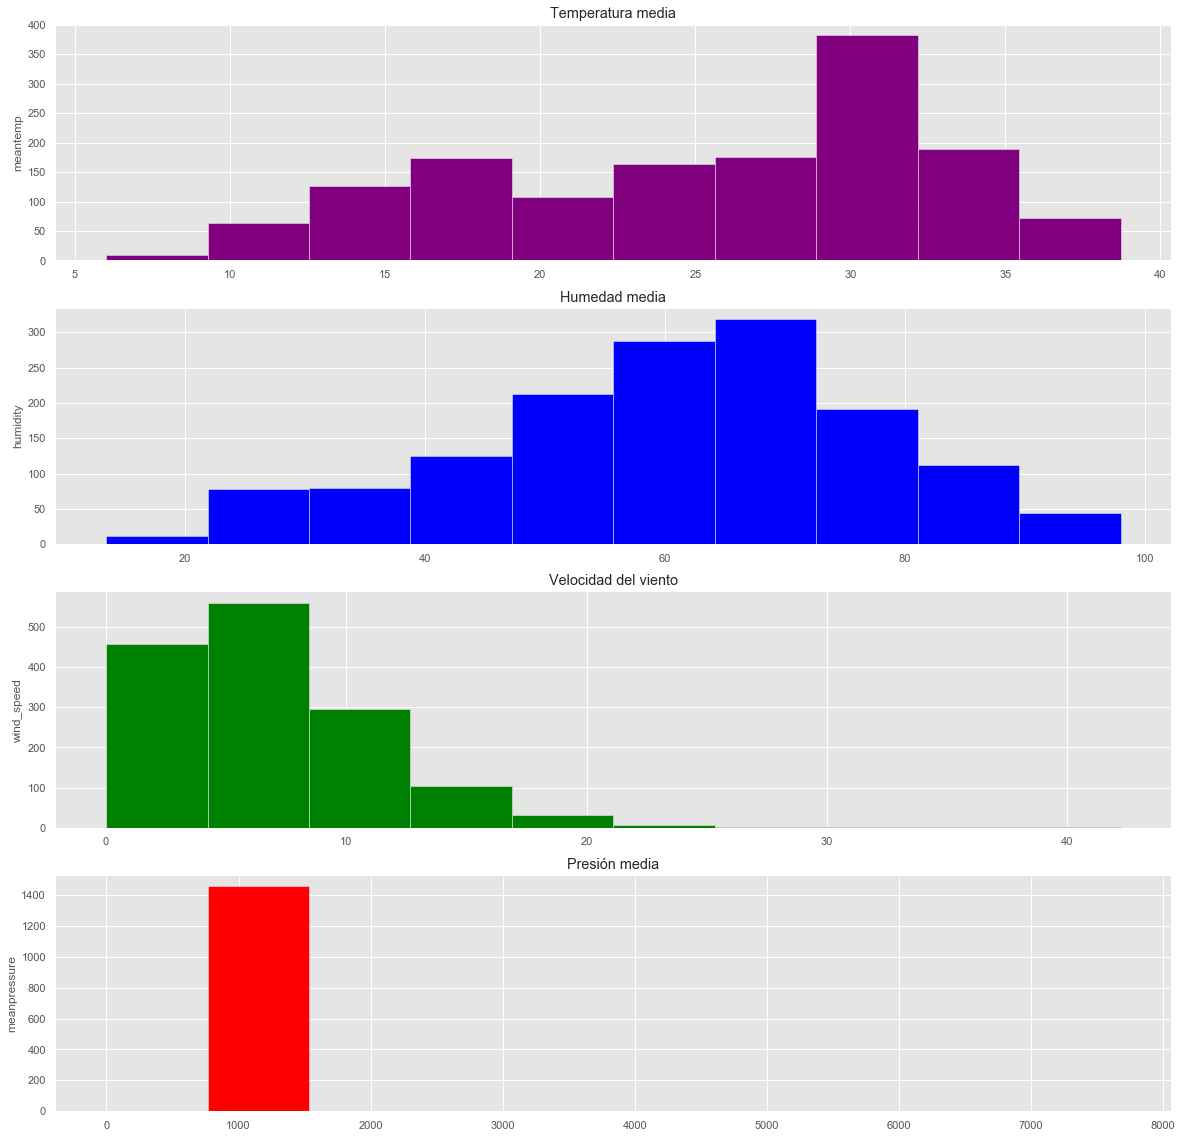

In [44]:
plt.style.use('ggplot')
plt.figure(figsize=(20,20))


plt.subplot(411)
plt.hist(df['meantemp'],color='purple')
plt.ylabel("meantemp")
plt.title('Temperatura media')


plt.subplot(412)
plt.hist(df['humidity'],color='blue')
plt.ylabel("humidity")
plt.title('Humedad media')

plt.subplot(413)
plt.hist(df['wind_speed'],color='green')
plt.ylabel("wind_speed")
plt.title('Velocidad del viento')

plt.subplot(414)
plt.hist(df['meanpressure'],color='red')
plt.ylabel("meanpressure")
plt.title('Presión media')

plt.show()

***Se muestra la distribución de los parámetros ambientales. Se puede apreciar los outliers en la presión anteiormente mencionados. Para su mejor comprensión se incluiran visualizaciones sin esta data en adelante. De los parámetros se puede comentar que cada uno tiene su propio sesgo y se distribuye relativamente normal respecto a este. La presión sin outliers por su parte sigue siendo el dato más atípico en el dataframe.***

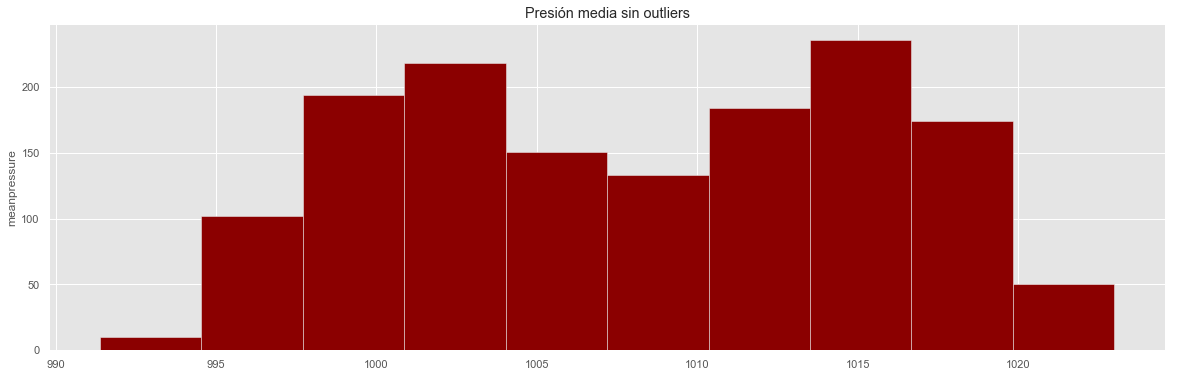

In [45]:
plt.figure(figsize=(20,6))
plt.hist(df[(np.abs(stats.zscore(df['meanpressure'])) < 0.2)]['meanpressure'],color='darkred')
plt.ylabel("meanpressure")
plt.title('Presión media sin outliers')
plt.show()


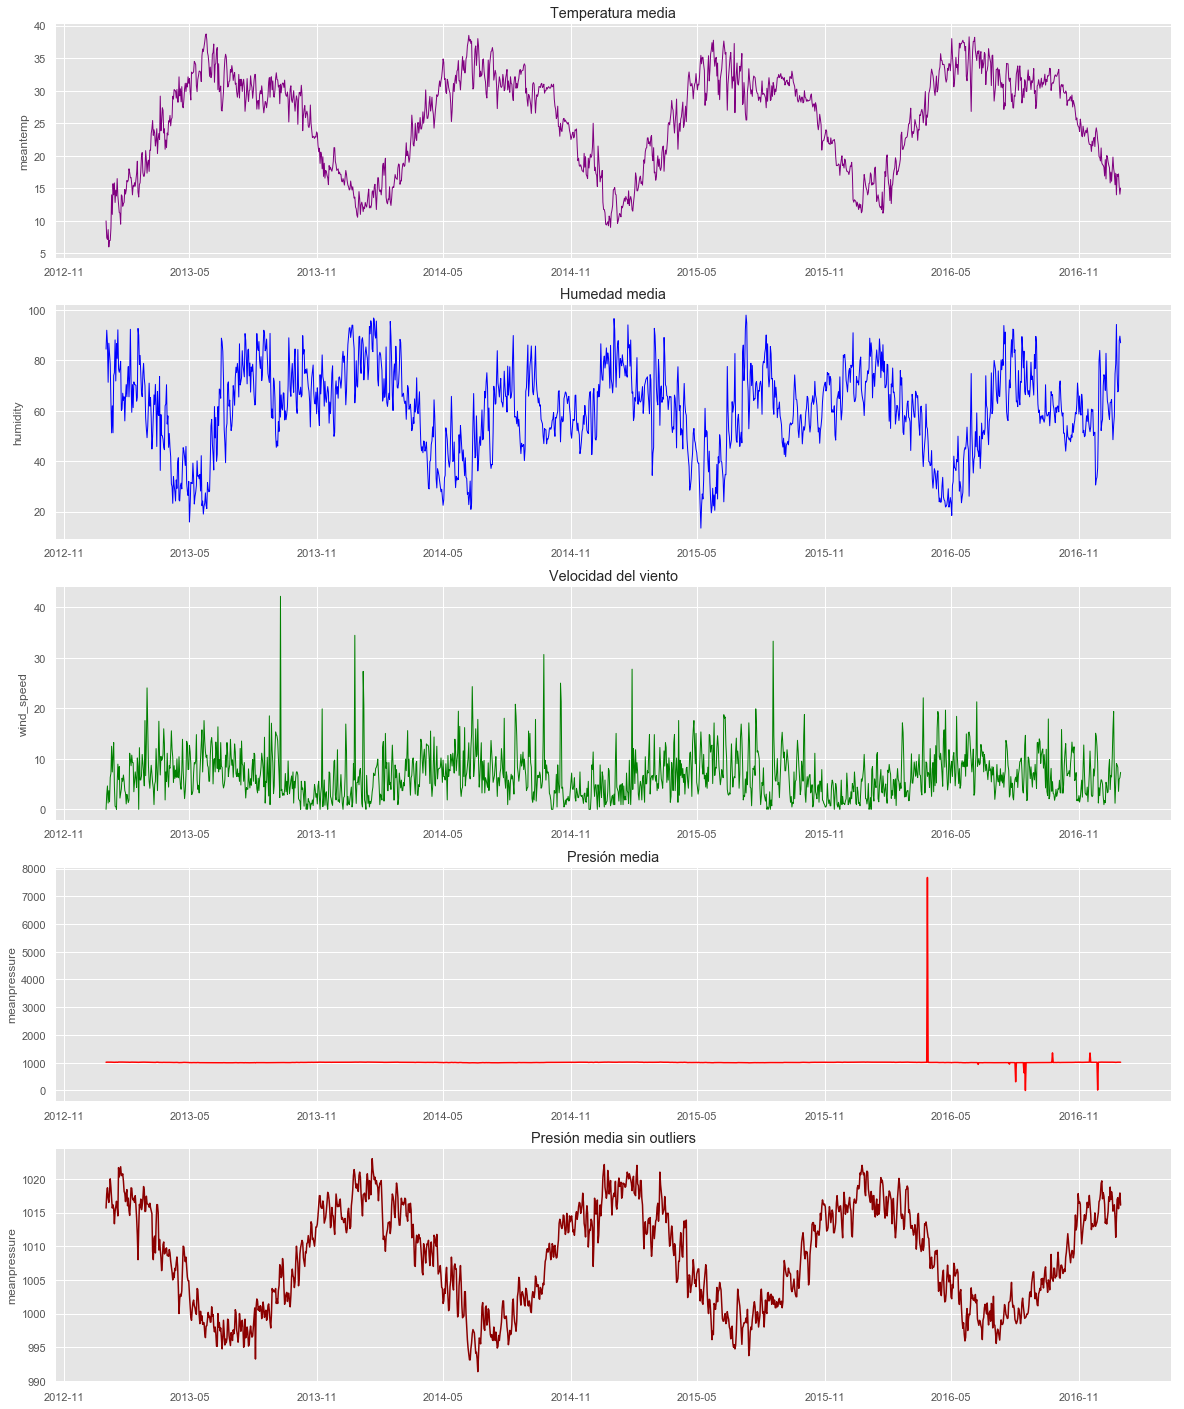

In [46]:
plt.figure(figsize=(20,25))


plt.subplot(511)
plt.plot(df['date'], df['meantemp'],c='purple',linewidth=1)
plt.ylabel("meantemp")
plt.title('Temperatura media')


plt.subplot(512)
plt.plot(df['date'], df['humidity'],c='blue',linewidth=1)
plt.ylabel("humidity")
plt.title('Humedad media')

plt.subplot(513)
plt.plot(df['date'], df['wind_speed'],c='green',linewidth=1)
plt.ylabel("wind_speed")
plt.title('Velocidad del viento')

plt.subplot(514)
plt.plot(df['date'], df['meanpressure'],c='red')
plt.ylabel("meanpressure")
plt.title('Presión media')

plt.subplot(515)
plt.plot(df[(np.abs(stats.zscore(df['meanpressure'])) < 0.2)]['date'], df[(np.abs(stats.zscore(df['meanpressure'])) < 0.2)]['meanpressure'],c='darkred')
plt.ylabel("meanpressure")
plt.title('Presión media sin outliers')

plt.show()

***De las series de tiempo se puede rescatar la estacionalidad de la data, por lo que si sera relevante y aportara al problema agregar esta información al modelo. Pese a la estacionalidad de esta, la tendencia puede variar considerablemente de un día a otro. En el caso de la temperatura en promedio hay margenes de cinco grados, lo que es relevante para la persona que mira el pronostico diario del tiempo. El viento es el que muestra más variante pero aún así se puede ver una media movil a traves del año.***

In [47]:
#dummy df para rescalar datos y comparar las distintas escalas
dummy = df[params+['month','year']].copy()
#agrupar por mes y año
dummy = dummy.groupby(['year','month']).mean().reset_index()
for para in params:
    dummy[para] = (dummy[para]-dummy[para].min())/(dummy[para].max()-dummy[para].min())
dummy['date'] = dummy['year'].astype(str) +'-'+dummy['month'].astype(str)
dummy["date"] = pd.to_datetime(dummy["date"])

#hacer lo mismo para la presión sin outliers

pressure_2 = df[(np.abs(stats.zscore(df['meanpressure'])) < 0.3)][['year','month','meanpressure','meantemp']]
pressure_2 = pressure_2.groupby(['year','month']).mean().reset_index()
pressure_2['meanpressure'] = (pressure_2['meanpressure']-pressure_2['meanpressure'].min())/(pressure_2['meanpressure'].max()-pressure_2['meanpressure'].min())
pressure_2['date'] = pressure_2['year'].astype(str) +'-'+pressure_2['month'].astype(str)
pressure_2["date"] = pd.to_datetime(dummy["date"])


Text(0,0.5,'meantemp')

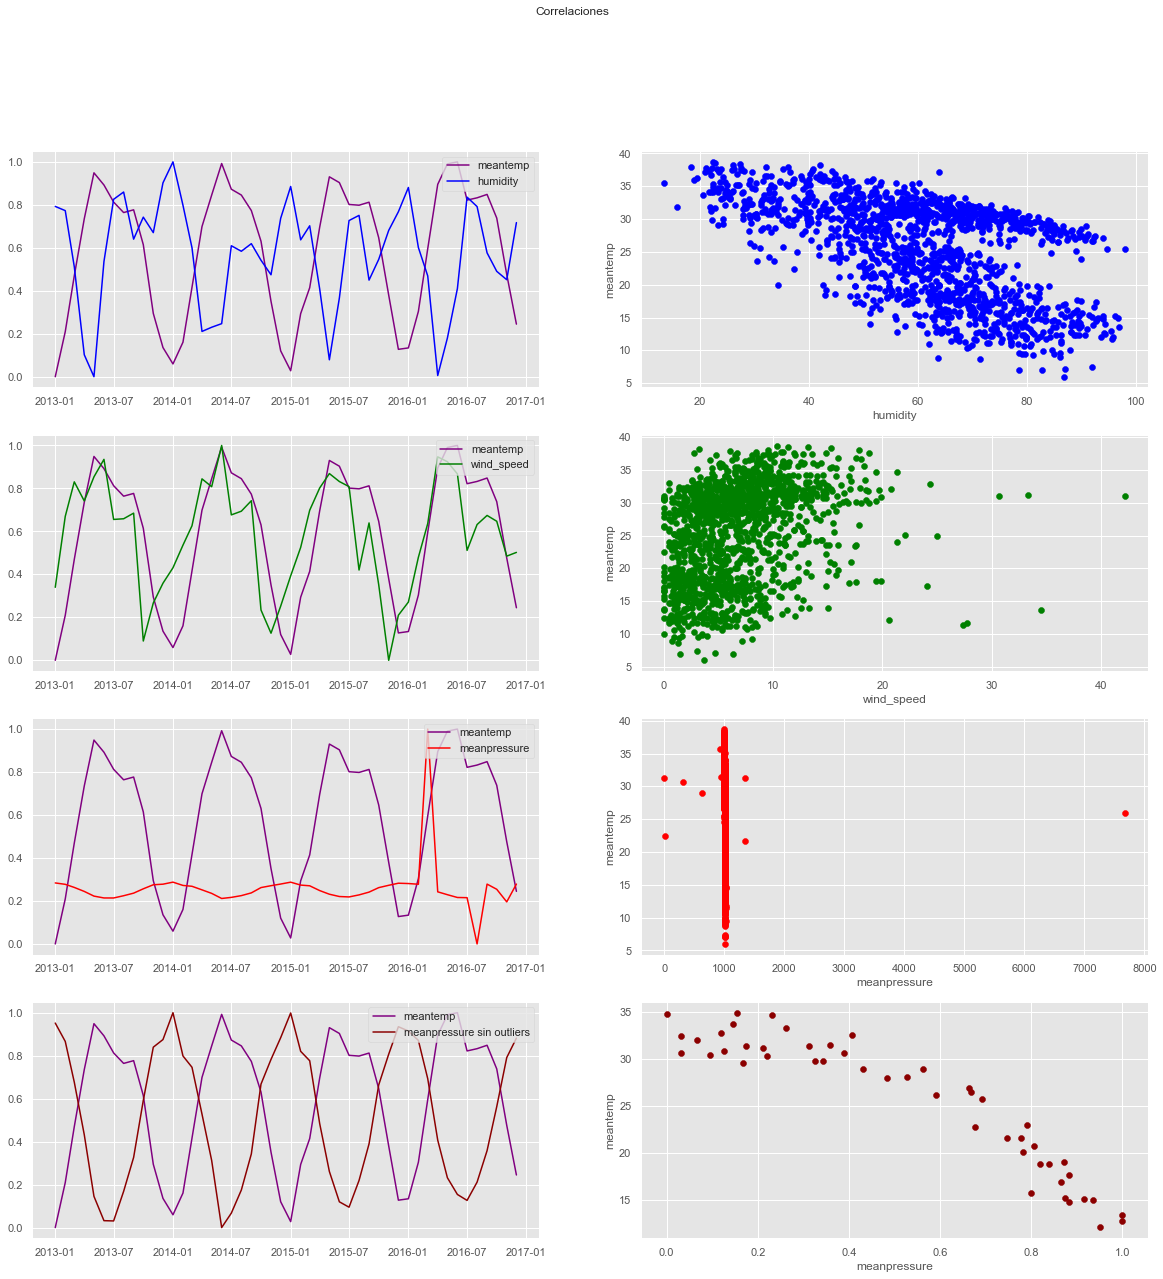

In [48]:
#plot by month,year
plt.figure(figsize=(20,20))
plt.suptitle('Correlaciones')

plt.subplot(421)
plt.plot(dummy['date'], dummy['meantemp'],c='purple')
plt.plot(dummy['date'], dummy['humidity'],c='blue')
plt.legend(loc='upper right')

plt.subplot(422)
plt.scatter(df['humidity'], df['meantemp'],c='blue')
plt.xlabel("humidity")
plt.ylabel("meantemp")


plt.subplot(423)
plt.plot(dummy['date'], dummy['meantemp'],c='purple')
plt.plot(dummy['date'], dummy['wind_speed'],c='green')
plt.legend(loc='upper right')

plt.subplot(424)
plt.scatter(df['wind_speed'], df['meantemp'],c='green')
plt.xlabel("wind_speed")
plt.ylabel("meantemp")


plt.subplot(425)
plt.plot(dummy['date'], dummy['meantemp'],c='purple')
plt.plot(dummy['date'], dummy['meanpressure'],c='red')
plt.legend(loc='upper right')

plt.subplot(426)
plt.scatter(df['meanpressure'], df['meantemp'],c='red')
plt.xlabel("meanpressure")
plt.ylabel("meantemp")


plt.subplot(427)
plt.plot(dummy['date'], dummy['meantemp'],c='purple')
plt.plot(pressure_2['date'], pressure_2['meanpressure'],c='darkred',label='meanpressure sin outliers')
plt.legend(loc='upper right')

plt.subplot(428)
plt.scatter(pressure_2['meanpressure'], pressure_2['meantemp'],c='darkred')
plt.xlabel("meanpressure")
plt.ylabel("meantemp")

***Los gráficos de la izquierda muestran el promedio mensual de cada párametro con el objetivo de eliminar el ruido, se normalizan de 0 a 1, y se comparan con la temperatura del día (que es el dato que supuestamente esta más cercano al que se quiere predecir, el del día siguiente). Así se captura el movimiento promedio en cada estación. A la derecha esta la relación directa atemporal entre las variables.***

***De los gráficos se rescata, generalmente, una corelación positiva entre la temperatura y el nivel del viento. Es decir a mayor velocidad del viento mayor temperatura. Y en general una negativa entre la presión del aire y la humedad. En el caso de la presión queda de manera más clara, donde cada máximo de temperatura coincide con el mínimo de presión, independiente de la fecha.***

***Las diferencias en estos comportamientos que se ven en la serie de tiempo se pueden atribuir a las distintas estaciones, por lo que no hay que presumir una causalidad total entre estas variables. Sin embargo, se puede concluir que se esta incorporando información relevante adicional a un modelo si no solo se toma en cuenta la información del día anterior. Siempre y cuando se encuentre relativamente cerca de la ventana estacional, dado que existe mucho ruido fuera de ellas.***

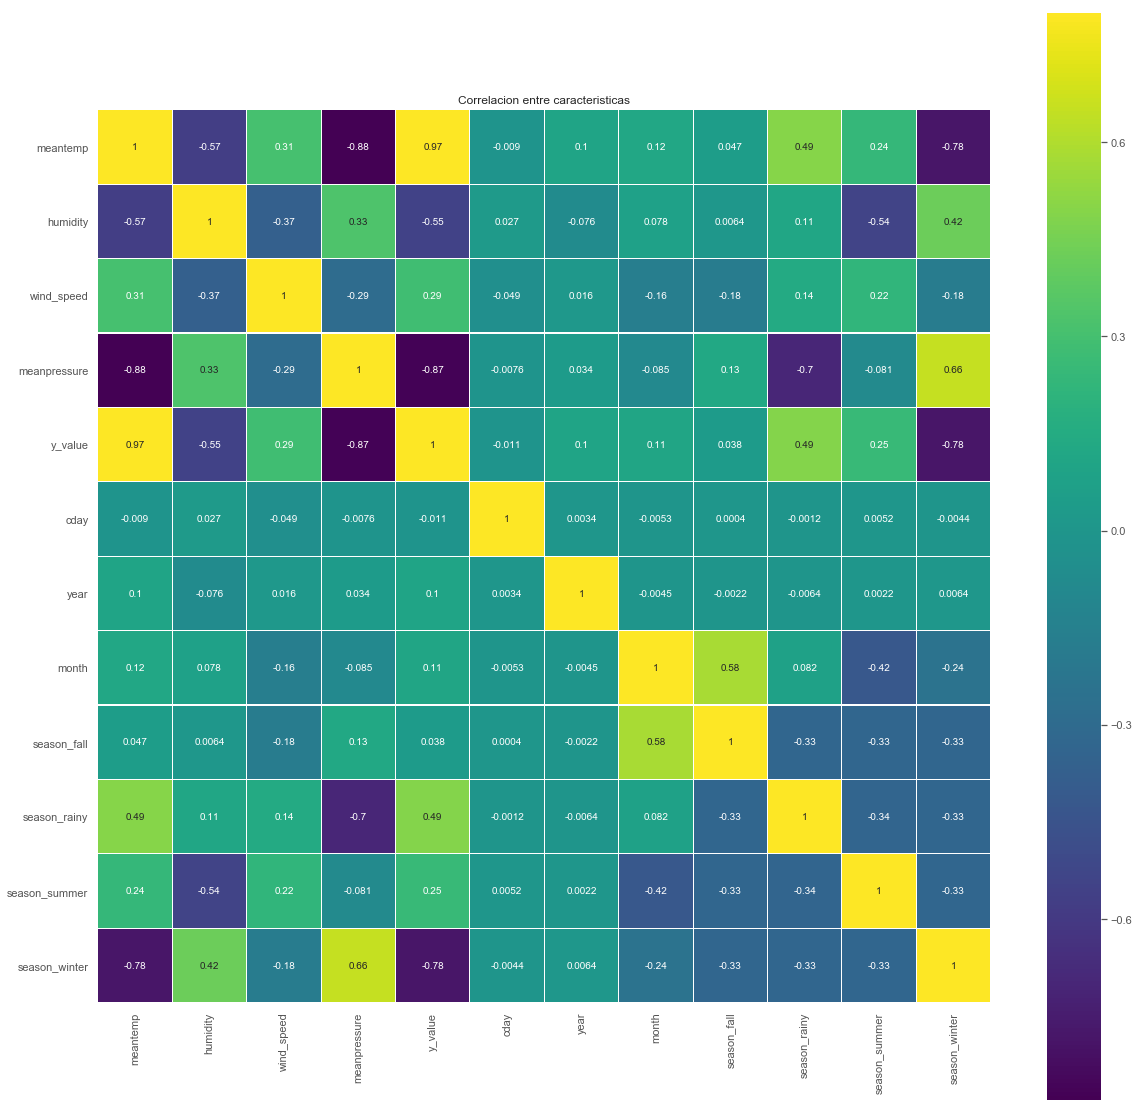

In [49]:
plt.figure(figsize=(20,20))
sns.heatmap(df[(np.abs(stats.zscore(df['meanpressure'])) < 0.3)].corr(), vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
sns.set(font_scale=1)
plt.title('Correlacion entre caracteristicas');
plt.show()

***Finalmente se muestran todas las correlaciones entre los atributos, se puede corroborar que además de los cuatro parámetros iniciales, las estaciones otorgan información valiosa para el valor de la temperatura. Siendo la data de las fechas en sí las menos correlacionadas, con el día de la semana la menos relevante.***

> b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?

In [50]:
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [51]:
#Proceso para regularizar el modelo
def do_Tree(x,y,xv,yv, param_d=None, param_m=2):
    model= Tree()
    #print("Param Max-D= ",param_d, 'Min-samples-S= ', param_m)
    model.set_params(max_depth=param_d, min_samples_split=param_m) 
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Depths = np.arange(1,300, 10) #choose steps
SamplesS = np.arange(2, X_train.shape[0] , 10 ) #choose steps

ltrain = np.zeros(shape=(Depths.shape[0],SamplesS.shape[0])) 
ltest  = np.zeros(shape=(Depths.shape[0],SamplesS.shape[0])) 
for i in range(Depths.shape[0]):
    for j in range(SamplesS.shape[0]):
        model, train_acc, test_acc = do_Tree(X_train,y_train,X_val,y_val, param_d = Depths[i], param_m=SamplesS[j])
        ltrain[i][j] = train_acc
        ltest[i][j]  = test_acc

Máximo test_acc: 0.943, Max depth óptimo: 11 Min samples óptimo: 142
	 train_acc: 0.942


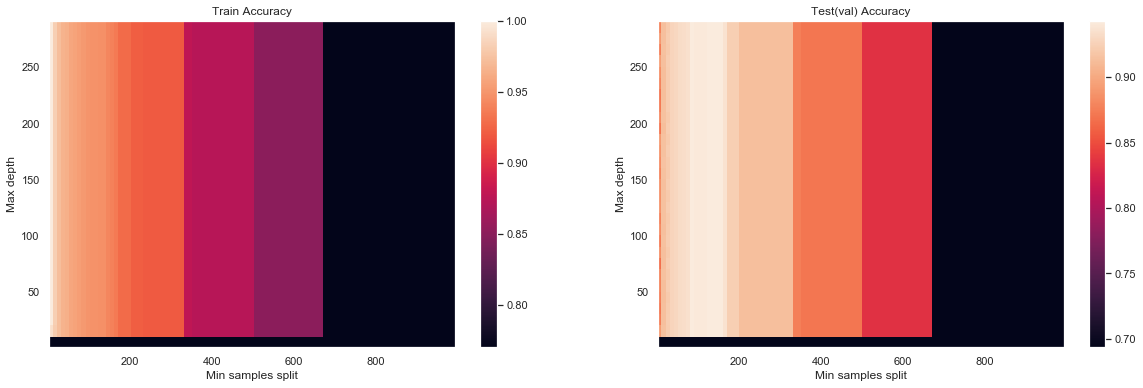

In [52]:
%matplotlib inline
#test = np.asarray(zs_train,).reshape(200,200)
#print(len(xs_train))

plt.figure(figsize=(20,6))

plt.subplot(121)
plt.pcolormesh(SamplesS,Depths,ltrain)#,vmin=0, vmax=1)
plt.title("Train Accuracy")
plt.xlabel("Min samples split")
plt.ylabel("Max depth")
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(SamplesS,Depths,ltest)#,vmin=0, vmax=1)
plt.title("Test(val) Accuracy")
plt.xlabel("Min samples split")
plt.ylabel("Max depth")
plt.colorbar()

m = -1
k = -1
l = -1

for i in range(Depths.shape[0]):
    for j in range(SamplesS.shape[0]):
        if ltest[i][j] > m:
            m = ltest[i][j]
            k = i
            l = j

print("Máximo test_acc: "+str(round(m,4)) + ", Max depth óptimo: "+ str(round(Depths[k],4)) + " Min samples óptimo: "+ str(round(SamplesS[l],4)))
print("\t train_acc: "+str(round(ltrain[k][l],4)))

In [68]:
#Modelo regularizado
model = Tree(max_depth=11 ,min_samples_split=142)
model.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=142, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

***Otros tipos de modelos requieren que cada variable use la misma escala para poder generar calculos y relaciones entre ellas. Un árbol de regresión no necesita ser escalado debido a que el operador base (split) actua de manera independiente los ordenes de magnitud. El punto en el que fija una separación no afecta a la predicción al sumar o multiplicar cada variable por una constante, debido a que la posición del punto siempre sera relativa al dominio de la data.***

***Se hace una pequeña búsqueda para los párametros min samples split y max depth, la métrica de elección es la precisión simple. En ambos se tiene un mayor impacto en la mínima cantidad de datos en un split. Esta se muestra ser generalmente mejor en cuanto menor es el número. Lo que hace sentido en el conjunto de training, debido a la tendencia a overtfit, sin embargo en el conjunto de validación se comporto de forma similar.***

> c) Para evaluar la calidad de predicción en este problema se utilizará la métrica Root Mean Squared Error (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización vs el no regularizar.

RMSE train (Modelo regularizado)=  1.7929664478531246
RMSE val (Modelo regularizado)=  1.691606916307517

RMSE train (Modelo no regularizado)=  0.0
RMSE val (Modelo no regularizado)=  2.521541959927073


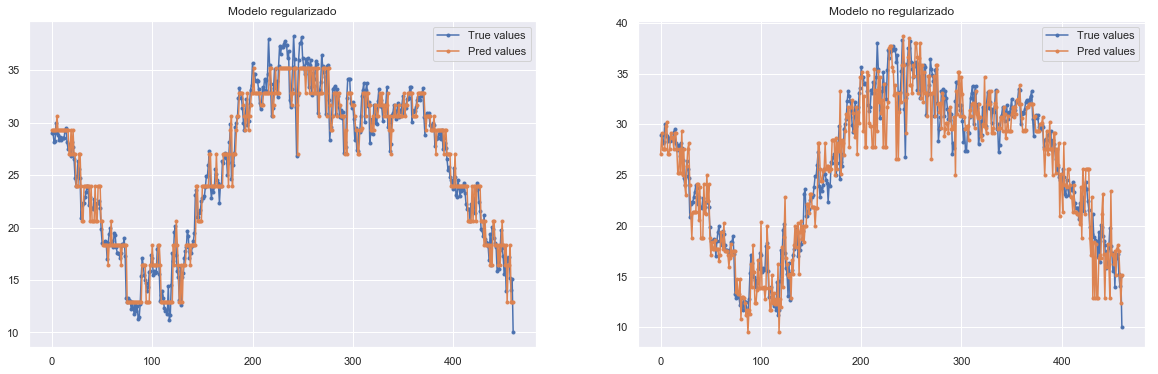

In [69]:
#Modelo regularizado
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)
print("RMSE train (Modelo regularizado)= ",RMSE(y_train,y_train_hat))
print("RMSE val (Modelo regularizado)= ",RMSE(y_val,y_val_hat))

plt.figure(figsize=(20,6))

plt.subplot(121)
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.title('Modelo regularizado')
plt.legend()

#Modelo no regularizado
y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("\nRMSE train (Modelo no regularizado)= ",RMSE(y_train,y_train_hat))
print("RMSE val (Modelo no regularizado)= ",RMSE(y_val,y_val_hat))

plt.subplot(122)
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.title('Modelo no regularizado')
plt.legend()

***Para el ábol regularizado se realizo un muestreo de valores para su áltura máxima y la mínima cantidad de muestras por split, el resto de párametros se dejo sin regularizar. En el modelo no regularizado se observa un overfit completo, con un error cuadrático medio de cero básicamente. El error en el conjunto de validación es menor para el conjunto regularizado.***

> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de Bagging, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en b)) ¿Qué debería suceder? ¿Se visualiza overfitting? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

In [71]:
from sklearn.ensemble import BaggingRegressor

#Modelo regularizado
rmse_train_r=[]
rmse_val_r=[]

N_estimators=range(1,200,2)

for i in N_estimators:
    model = BaggingRegressor(base_estimator=Tree(max_depth=11,min_samples_split=142), n_estimators=i, n_jobs=-1)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    rmse_train_r.append(RMSE(y_train,y_train_hat))
    rmse_val_r.append(RMSE(y_val,y_val_hat))

#Modelo mo regularizado
rmse_train=[]
rmse_val=[]

for i in N_estimators:
    model = BaggingRegressor(base_estimator=Tree(), n_estimators=i, n_jobs=-1)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    rmse_train.append(RMSE(y_train,y_train_hat))
    rmse_val.append(RMSE(y_val,y_val_hat))

Regularized RMS at 1:  2.056
Regularized RMS at 6:  1.765
Regularized RMS at 50:  1.784
Regularized RMS at 200:  1.79
Non regularized RMS at 1:  2.537
Non regularized RMS at 6:  1.806
Non regularized RRMS at 50:  1.739
Non regularized RRMS at 200:  1.669

Min RMS:  1.6482330145916702  at N:  82 estimators regularizated


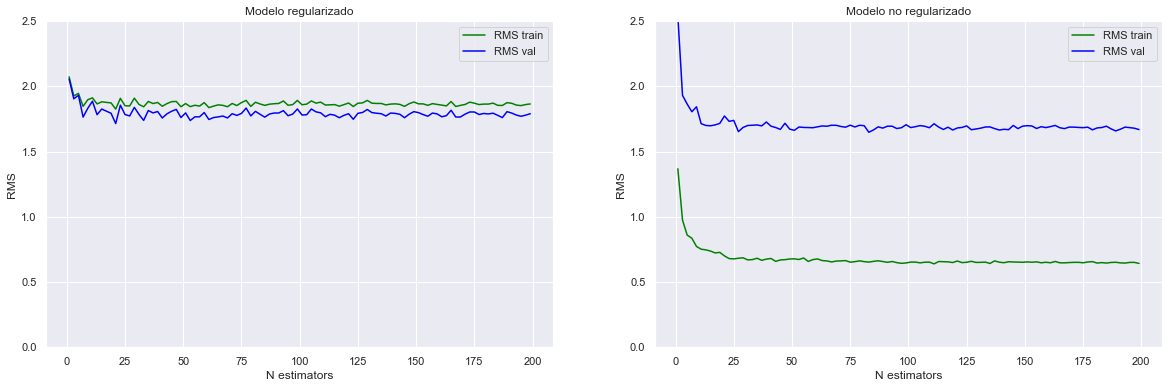

In [72]:
plt.figure(figsize=(20,6))

#Modelo regularizado
plt.subplot(121)
plt.plot(N_estimators, rmse_train_r, c = 'green', label = 'RMS train')
plt.plot(N_estimators, rmse_val_r, c = 'blue', label = 'RMS val')
plt.xlabel("N estimators")
plt.ylabel("RMS")
plt.title('Modelo regularizado')
plt.ylim(0,2.5)
plt.legend()

#Modelo no regularizado
plt.subplot(122)
plt.plot(N_estimators, rmse_train, c = 'green', label = 'RMS train')
plt.plot(N_estimators, rmse_val, c = 'blue', label = 'RMS val')
plt.xlabel("N estimators")
plt.ylabel("RMS")
plt.title('Modelo no regularizado')
plt.ylim(0,2.5)
plt.legend()

print('Regularized RMS at 1: ', round(rmse_val_r[0],3))
print('Regularized RMS at 6: ', round(rmse_val_r[3],3))
print('Regularized RMS at 50: ', round(rmse_val_r[12],3))
print('Regularized RMS at 200: ', round(rmse_val_r[99],3))

print('Non regularized RMS at 1: ', round(rmse_val[0],3))
print('Non regularized RMS at 6: ', round(rmse_val[3],3))
print('Non regularized RRMS at 50: ', round(rmse_val[12],3))
print('Non regularized RRMS at 200: ', round(rmse_val[99],3))


print('')
min_re = 1e7
i_re = 0
min_unre = 1e7
i_unre = 0
for i in range(len(rmse_val_r)):
    if rmse_val[i] < min_re:
        min_unre = rmse_val[i]
        i_unre = i
        
for i in range(len(rmse_val)):
    if rmse_val[i] < min_re:
        min_re = rmse_val[i]
        i_re = i
if min_re < min_unre:
    print('Min RMS: ', min_re ,' at N: ', i_re*2,'estimators regularizated')
else:
    print('Min RMS: ', min_unre ,' at N: ', i_unre*2,'estimators non-regularizated')

***El método braging ayuda a reducir el error cuadrático medio. En ambos casos se muestra una tendencia a dismuir con el número de estimadores con ciertas diferencias aleatorias debido a los distintos modelos que se incorporan por iteración. Se puede apreciar que el modelo no regularizado no presenta overfitting, incluso el error de validación resulta ser menor que el de entrenamiento. El modelo no regularizado aún con la técnica tiene una tendencia mayor a centrarse en el conjunto de entrenamiento, sin embargo se puede mejorar lo suficiente para estar a un nivel cercano de los árboles regularizados en RMS***

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de AdaBoost, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en d) ¿Se visualiza overfitting? ¿Qué técnica utiliza la librería de sklearn, re-muestrear o pesar ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).

In [57]:
from sklearn.ensemble import AdaBoostRegressor

#Modelo regularizado
rmse_train_r=[]
rmse_val_r=[]

N_estimators=range(1,200,2)

for i in N_estimators:
    model = AdaBoostRegressor(base_estimator=Tree(max_depth=11,min_samples_split=142), n_estimators=i)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    rmse_train_r.append(RMSE(y_train,y_train_hat))
    rmse_val_r.append(RMSE(y_val,y_val_hat))

#Modelo mo regularizado
rmse_train=[]
rmse_val=[]

for i in N_estimators:
    model = AdaBoostRegressor(base_estimator=Tree(), n_estimators=i)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    rmse_train.append(RMSE(y_train,y_train_hat))
    rmse_val.append(RMSE(y_val,y_val_hat))

Regularized RMS at 1:  1.787
Regularized RMS at 6:  1.696
Regularized RMS at 25:  1.712
Regularized RMS at 200:  1.761
Non regularized RMS at 1:  2.454
Non regularized RMS at 6:  1.816
Non regularized RRMS at 25:  1.824
Non regularized RRMS at 200:  1.716

Min RMS:  1.6799950197905633  at N:  102 estimators in regularizated


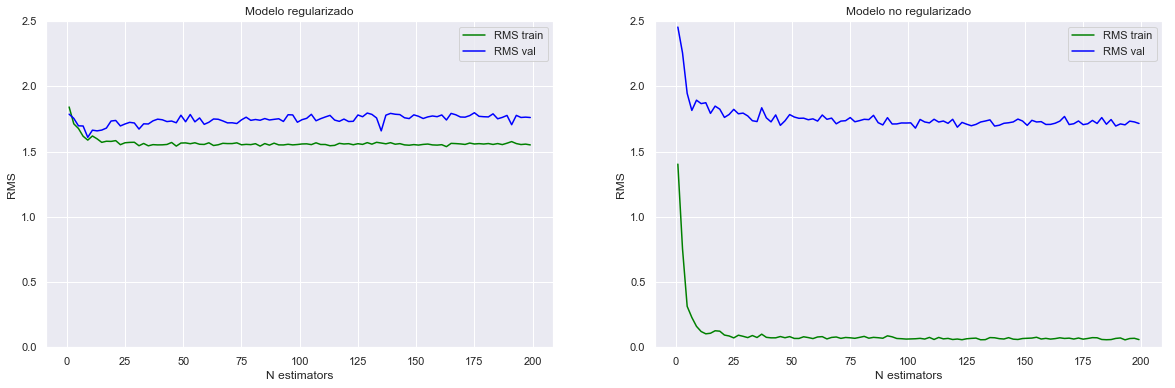

In [58]:
plt.figure(figsize=(20,6))

#Modelo regularizado
plt.subplot(121)
plt.plot(N_estimators, rmse_train_r, c = 'green', label = 'RMS train')
plt.plot(N_estimators, rmse_val_r, c = 'blue', label = 'RMS val')
plt.xlabel("N estimators")
plt.ylabel("RMS")
plt.title('Modelo regularizado')
plt.ylim(0,2.5)
plt.legend()

#Modelo no regularizado
plt.subplot(122)
plt.plot(N_estimators, rmse_train, c = 'green', label = 'RMS train')
plt.plot(N_estimators, rmse_val, c = 'blue', label = 'RMS val')
plt.xlabel("N estimators")
plt.ylabel("RMS")
plt.title('Modelo no regularizado')
plt.ylim(0,2.5)
plt.legend()

print('Regularized RMS at 1: ', round(rmse_val_r[0],3))
print('Regularized RMS at 6: ', round(rmse_val_r[3],3))
print('Regularized RMS at 25: ', round(rmse_val_r[12],3))
print('Regularized RMS at 200: ', round(rmse_val_r[99],3))

print('Non regularized RMS at 1: ', round(rmse_val[0],3))
print('Non regularized RMS at 6: ', round(rmse_val[3],3))
print('Non regularized RRMS at 25: ', round(rmse_val[12],3))
print('Non regularized RRMS at 200: ', round(rmse_val[99],3))

print('')
min_re = 1e7
i_re = 0
min_unre = 1e7
i_unre = 0
for i in range(len(rmse_val_r)):
    if rmse_val[i] < min_re:
        min_unre = rmse_val[i]
        i_unre = i
        
for i in range(len(rmse_val)):
    if rmse_val[i] < min_re:
        min_re = rmse_val[i]
        i_re = i
if min_re < min_unre:
    print('Min RMS: ', min_re ,' at N: ', i_re*2,'estimators in regularizated')
else:
    print('Min RMS: ', min_unre ,' at N: ', i_unre*2,'estimators in non-regularizated')

***Se puede ver qué el valor de error cuadrático medio en el conjunto de entrenamiento es muy cercano a cero en el no regularizado, por lo que si se puede argumentar que existe un sobreajuste sobre este conjunto. La téncica utilizada en AdaBoost a diferencia del bagging es que crea nuevos árboles que se centran en estimar bien los datos que los árboles anteriores tuvieron problemas. Esto conlleva a que se estime de muy buena manera bajo el conjunto de entrenamiento, creando el overfit, sin embargo esto se compensa al crear varios árboles como se muestra en la figura son resultados similares a su contraparte en validación.***

***Comparando los resultados con bagging se tienen resultados peores en el conjunto de validación (1.648 vs 1.679). Se muestra una ligera tendencia a empeorar el desempeño con los árboles regularizados conforme se aumenta el número de estimadores. En cuanto con el modelo no regularizado se estima mejor con una mayor cantidad de participantes como ocurría en bagging.***

> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo boostrap de Bagging con muestreo sobre las features: Random Forest, compare el Árbol no regularizado con el regularizado ¿Se visualiza overfitting?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

In [59]:
from sklearn.ensemble import RandomForestRegressor

#Modelo regularizado
rmse_train_r=[]
rmse_val_r=[]

N_estimators=range(1,200,2)

for i in N_estimators:
    model = RandomForestRegressor(n_estimators=i,max_depth=11,min_samples_split=142, n_jobs=-1)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    rmse_train_r.append(RMSE(y_train,y_train_hat))
    rmse_val_r.append(RMSE(y_val,y_val_hat))

#Modelo mo regularizado
rmse_train=[]
rmse_val=[]

for i in N_estimators:
    model = RandomForestRegressor(n_estimators=i, n_jobs=-1)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    rmse_train.append(RMSE(y_train,y_train_hat))
    rmse_val.append(RMSE(y_val,y_val_hat))

Regularized RMS at 1:  2.231
Regularized RMS at 6:  1.891
Regularized RMS at 25:  1.911
Regularized RMS at 200:  1.753
Non regularized RMS at 1:  2.416
Non regularized RMS at 6:  1.763
Non regularized RRMS at 25:  1.707
Non regularized RRMS at 200:  1.688

Min RMS:  1.6611782754022477  at N:  98 estimators in regularizated


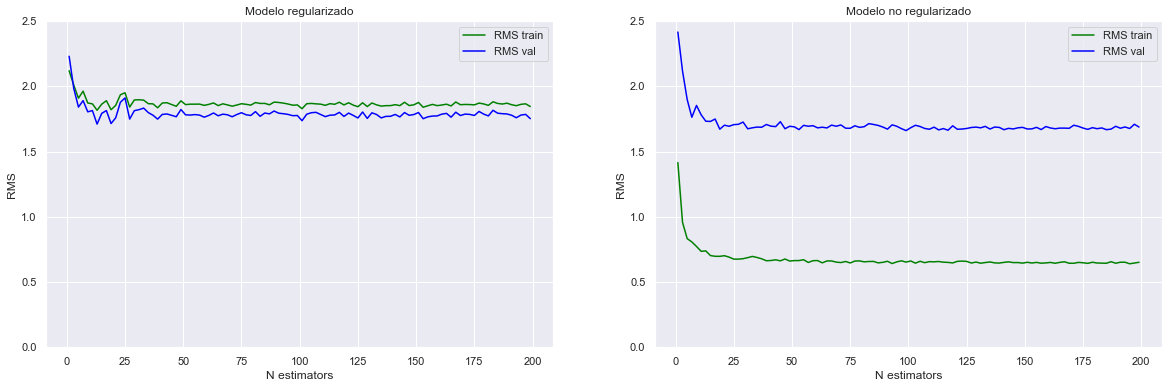

In [60]:
plt.figure(figsize=(20,6))

#Modelo regularizado
plt.subplot(121)
plt.plot(N_estimators, rmse_train_r, c = 'green', label = 'RMS train')
plt.plot(N_estimators, rmse_val_r, c = 'blue', label = 'RMS val')
plt.xlabel("N estimators")
plt.ylabel("RMS")
plt.title('Modelo regularizado')
plt.ylim(0,2.5)
plt.legend()

#Modelo no regularizado
plt.subplot(122)
plt.plot(N_estimators, rmse_train, c = 'green', label = 'RMS train')
plt.plot(N_estimators, rmse_val, c = 'blue', label = 'RMS val')
plt.xlabel("N estimators")
plt.ylabel("RMS")
plt.title('Modelo no regularizado')
plt.ylim(0,2.5)
plt.legend()

print('Regularized RMS at 1: ', round(rmse_val_r[0],3))
print('Regularized RMS at 6: ', round(rmse_val_r[3],3))
print('Regularized RMS at 25: ', round(rmse_val_r[12],3))
print('Regularized RMS at 200: ', round(rmse_val_r[99],3))

print('Non regularized RMS at 1: ', round(rmse_val[0],3))
print('Non regularized RMS at 6: ', round(rmse_val[3],3))
print('Non regularized RRMS at 25: ', round(rmse_val[12],3))
print('Non regularized RRMS at 200: ', round(rmse_val[99],3))

print('')
min_re = 1e7
i_re = 0
min_unre = 1e7
i_unre = 0
for i in range(len(rmse_val_r)):
    if rmse_val[i] < min_re:
        min_unre = rmse_val[i]
        i_unre = i
        
for i in range(len(rmse_val)):
    if rmse_val[i] < min_re:
        min_re = rmse_val[i]
        i_re = i
if min_re < min_unre:
    print('Min RMS: ', min_re ,' at N: ', i_re*2,'estimators in regularizated')
else:
    print('Min RMS: ', min_unre ,' at N: ', i_unre*2,'estimators in non-regularizated')

***Se visualiza un grado menor de overfitting que en AdaBoost en el no regularizado, pero aún así los mejores resultados son usando bagging (1.648 vs 1.679). En terminos de comportamiento conforme aumenta al número de estimadores es mucho más similar a bagging.***

> g) Verifique que el OOB error (out of bag error) de los ensambladores que utilizan la técnica boostrap puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto cross validation).

In [89]:
#Bagging 
model = BaggingRegressor(base_estimator=Tree(max_depth=11,min_samples_split=142), oob_score=True,n_estimators=82, n_jobs=-1)
model.fit(X_train,y_train)
oob_error = model.oob_score_
val_error = model.score(X_val,y_val)
print("Bagging")
print("OOB error: ",oob_error)
print ("Val error: ",val_error)

#Random forests 
model = RandomForestRegressor(n_estimators=100,max_depth=11,min_samples_split=142,oob_score=True,n_jobs=-1)
model.fit(X_train,y_train)
oob_error = model.oob_score_
val_error = model.score(X_val,y_val)
print("\nRandom forests")
print("OOB error: ",oob_error)
print ("Val error: ",val_error)

Bagging
OOB error:  0.9300075032404487
Val error:  0.9357911623334585

Random forests
OOB error:  0.9306421432700129
Val error:  0.9359905518407777


***Tanto como en Bagging como con Random forests se tiene un error similar en VAL y OOB. Esto significa que no se esta prefiriendo un sub-conjunto sobre otro en la generación de árboles, lo que conlleva a sugerir que se esta generalizando de manera correcta con ambos algoritmos.***

> h) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo Bagging realiza el voto de la mayoría para clasificación y promedio para regresión, AdaBoost realiza una combinación ponderada de cada clasificador dependiendo de su habilidad (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ($Q_1$) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ($Q_2$) o mediana para ser robusto a predicciones atípicas de modelos. 

In [88]:
def combine_predictions_mean(predictions):
    return np.mean(predictions)
def combine_predictions_median(predictions):
    return np.median(predictions)
def combine_predictions_p_mean(predictions):
    min_q = np.percentile(predictions,10)
    max_q = np.percentile(predictions,90)
    p = list()
    for i in predictions[0]:
        if i < max_q and i > min_q:
            p.append(i)
    return np.mean(p)

def combine_predictions_p_median(predictions):
    min_q = np.percentile(predictions,10)
    max_q = np.percentile(predictions,90)
    p = list()
    for i in predictions[0]:
        if i < max_q and i > min_q:
            p.append(i)
    return np.median(p)



list_estimators = model.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]


new_predictions = combine_predictions_mean(list_predictions)
print("Mean RMSE val= ",RMSE(y_val, new_predictions))
new_predictions = combine_predictions_median(list_predictions)
print("Median RMSE val= ",RMSE(y_val, new_predictions))

new_predictions = combine_predictions_p_mean(list_predictions)
print("Percentile Mean RMSE val= ",RMSE(y_val, new_predictions))
new_predictions = combine_predictions_p_median(list_predictions)
print("Percentile Median RMSE val= ",RMSE(y_val, new_predictions))


Mean RMSE val=  7.085578397089777
Median RMSE val=  7.118301976341598
Percentile Mean RMSE val=  7.08654520436484
Percentile Median RMSE val=  7.484762233991735


***Se compara los resultados calculando la media aritmética, la mediana y haciendo ambos con el 80% de los datos eliminando predicciones atípicas en Random Forest. Los mejores resultados se obtienen de todas formas usando como métrica el promedio de las estimaciones sin filtrar estimaciones fuera de lo común. Seguido por las medianas, donde si hay una pequeña mejora al quitar predicciones muy alejadas del común.***

> i) Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo 𝑇>100, se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.

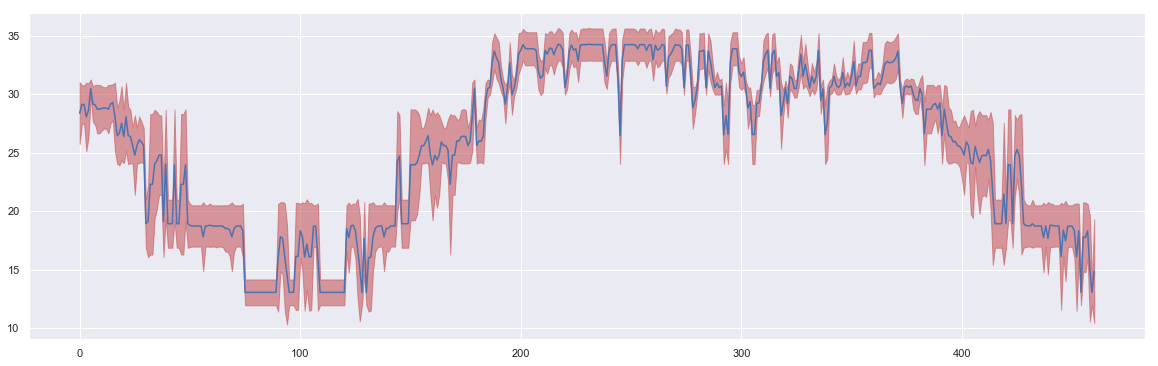

In [90]:
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(20,6))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()

***Se puede ver en la franja roja el intervalo de confianza donde se encuentra el 95% de las predicciones. Se puede ver de mejor manera como el método de esamblado de modelos puede lograr una buena estimación en base a un conjunto de modelos con tendencias distintas (asumiendo normalidad). El intervalo de confianza también entrega información útil respecto a la mínima y máxima esperada en un día.***

> j) Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.

In [91]:
df = pd.read_csv("DailyDelhiClimateTest.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable

df.drop(["date"], axis=1, inplace=True) #delete date
df['season_fall'] = 0
df['season_rainy'] = 0
df.head(5)



,meantemp,humidity,wind_speed,meanpressure,y_value,cday,year,month,season_summer,season_winter,season_fall,season_rainy
0,15.913043,85.869565,2.743478,59.000000,18.500000,6,2017,1,0,1,0,0
1,18.500000,77.222222,2.894444,1018.277778,17.111111,0,2017,1,0,1,0,0
2,17.111111,81.888889,4.016667,1018.333333,18.700000,1,2017,1,0,1,0,0
3,18.700000,70.050000,4.545000,1015.700000,18.388889,2,2017,1,0,1,0,0
4,18.388889,74.944444,3.300000,1014.333333,19.318182,3,2017,1,0,1,0,0


In [92]:
y_test = df.pop('y_value').values
X_test = df.values

In [105]:
model = BaggingRegressor(base_estimator=Tree(max_depth=11,min_samples_split=142), oob_score=True,n_estimators=82, n_jobs=-1)
model.fit(X_train,y_train)
y_predicted_BR_model = model.predict(X_test)
print("Test RMS Bagging:", RMSE(y_test, y_predicted_BR_model))

model = AdaBoostRegressor(base_estimator=Tree(max_depth=11,min_samples_split=142), n_estimators=102)
model.fit(X_train,y_train)

y_predicted_AB_model = model.predict(X_test)
print("Test RMS AdamBoost:", RMSE(y_test, y_predicted_AB_model))

model = RandomForestRegressor(n_estimators=98,max_depth=11,min_samples_split=142,oob_score=True,n_jobs=-1)
model.fit(X_train,y_train)
y_predicted_RFR_model_r = model.predict(X_test)
print("Test RMS Random Forest:", RMSE(y_test, y_predicted_RFR_model_r))



Test RMS Bagging: 1.9001259226545746
Test RMS AdamBoost: 1.8292814043656518
Test RMS Random Forest: 1.9245123185066864


***El modelo que obtuvo el mejor resultados en validación fue Bagging, luego Random Forest, y por último AdamBoost todos con árboles regularizados. En general se obtuvo que los árboles regularizados predicen mejor en el conjunto de validación, por lo que se espara que generalizen mejor. Los resultados en el conjunto de test arrojan un orden de precedencia: AdamBoost>Bagging>Random Forest. Una discrepancia que se asocia a que estos tres modelos ya obtenian resultados muy similares en todos los conjuntos, por lo que se atribuye a la estocasticidad de las técnicas este ligero desacuerdo.***

***Los principales resultados de esta experimentación arrojan que se puede reducir considerablemente el overfit, y aumentar su capacidad de generalización usando estrategias como regularizar hiper-parámeros o usando métodos de emsamblaje***